In [2]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict, Sequence, Tuple
import seaborn as sns
sns.set_palette("colorblind")

In [3]:
os.chdir("/home/edgan/projects/sketchstore/python")

In [4]:
import sketch.compress_freq
import sketch.sketch_frequent
import sketch.compress_dyadic
import sketch.sketch_gen
import storyboard.board_gen
import cube_board
import cube_rquery

In [5]:
def get_error_file(
    data_name: str, split_strategy: str,
    board_size: int, sketch_name: str,
    bias: bool, workload_p: float
) -> str:
    sketch_file = cube_board.get_file_name(data_name, split_strategy, board_size, sketch_name, bias)
    error_file = cube_rquery.transform_sketch_to_error_file(sketch_file, workload_p)
    return error_file

In [6]:
def human_format(x):
    sigpart = 0
    suffix = ""
    if x < .01:
        return "{:.1e}".format(x)
    if x < 1:
        return "{:.3f}".format(x)
    if x < 1000:
        return "{:.3g}".format(x)
    elif x < 1000000:
        sigpart = x / 1000
        suffix = "k"
    elif x < 1000000000:
        sigpart = x / 1000000
        suffix = "M"
    else:
        sigpart = x / 1000000000
        suffix = "B"
    return "{:.3g}{}".format(sigpart, suffix)
def bar_plot(ax, ys, yerr=None, log=False, label=False, ylims=None,lab_size=7):
    n = len(ys)
    xlocs = np.arange(0, n)
    colors = ["C0"] + ["C1"]*(len(ys)-1)
    ax.bar(
        xlocs,
        height=ys,
        yerr=yerr,
        log=log,
        color=colors,
    )
    if (label):
        rects = ax.patches
        for rect, label in zip(rects, ys):
            height = rect.get_height()
            y_pos = height
            if ylims is not None:
                if y_pos < ylims[0]:
                    y_pos = ylims[0]
            ax.text(
                rect.get_x() + rect.get_width()/2, 
                y_pos,
                human_format(label),
                ha='center', va='bottom', size = lab_size,
            )
    ax.set_xticks(xlocs)
def bar_plot_2(ax, ys, yerr=None, log=False, label=False, ylims=None, lab_size=7):
    n = len(ys)
    xlocs = np.arange(0, n)
    ax.barh(
        xlocs,
        width=ys,
        yerr=yerr,
        log=log,
    )
    if (label):
        rects = ax.patches
        for rect, label in zip(rects, ys):
            height = rect.get_height()
            width = rect.get_width()
            y_pos = width
            if ylims is not None:
                if y_pos < ylims[0]:
                    y_pos = ylims[0]
            ax.text(
                width, 
                rect.get_y()+height/2,
                human_format(label),
                ha='left', va='center', size = lab_size,
            )
    ax.set_yticks(xlocs)

In [7]:
method_names = {
    ("pps", "weighted@20", True): "Storyboard",
    ("random_sample", "uniform", False): "USample",
    ("random_sample", "prop", False): "USample:Prop",
    ("truncation", "uniform", False): "Truncation",
    ("cms_min", "uniform", False): "CMS",

    ("pps", "uniform", True): "SB (-Size Opt)",
    ("pps", "weighted@20", False): "SB (-Bias Opt)",
    ("pps", "weighted@5", True): "SB (Work1)",
    ("pps", "weighted@50", True): "SB (Work2)",
    ("random_sample", "weighted@20", True): "SB (-PPS)",
    ("random_sample", "sweighted@20", False): "STRAT",

    # Quantiles
    
    ("q_pps", "weighted@20", False): "Storyboard",
    ("q_random_sample", "uniform", False): "USample",
    ("q_random_sample", "prop", False): "USample:Prop",
    ("q_random_sample", "sweighted@20", False): "STRAT",
    ("q_truncation", "uniform", False): "Truncation",
    ("kll", "uniform", False): "KLL",

    ("q_pps", "uniform", False): "SB (-Size Opt)",
    ("q_random_sample", "weighted@20", False): "SB (-Bias Opt)",

}

colormap = {
    ("pps", "weighted@20", True): "C0",
    ("random_sample", "uniform", False): "C3",
    ("random_sample", "prop", False): "C2",
    ("truncation", "uniform", False): "C1",
    ("cms_min", "uniform", False): "C4",

    ("pps", "uniform", True): "C5",
    ("pps", "weighted@20", False): "C6",
    ("random_sample", "weighted@20", True): "C7",
    ("random_sample", "sweighted@20", False): "C8",
    
    ("q_pps", "weighted@20", False): "C0",
    ("q_random_sample", "uniform", False): "C3",
    ("q_random_sample", "prop", False): "C2",
    ("q_random_sample", "sweighted@20", False): "C8",
    ("q_truncation", "uniform", False): "C1",

}
markers = {
    ("pps", "weighted@20", True): "x",
    ("random_sample", "uniform", False): "+",
    ("random_sample", "prop", False): "s",
    ("truncation", "uniform", False): "^",
    ("cms_min", "uniform", False): "o",

    ("pps", "uniform", True): "<",
    ("pps", "weighted@20", False): ">",
    ("random_sample", "weighted@20", True): "D",
    ("random_sample", "sweighted@20", False): ".",
    
    ("q_pps", "weighted@20", False): "x",
    ("q_random_sample", "uniform", False): "+",
    ("q_random_sample", "prop", False): "s",
    ("q_random_sample", "sweighted@20", False): ".",
    ("q_truncation", "uniform", False): "^",

}
data_display_name = {
    "bsynthf@4": "Zipf",
    "bsynthq@4": "Uniform",
    "insta": "Instacart",
    "caida_10M": "CAIDA",
    "zipf1p1_10M": "Zipf",
    "msft_network_10M": "Provider",
    "msft_os_10M": "OSBuild",
    "power_2M": "Power",
    "uniform_1M": "Uniform",
    "msft_records_10M": "Traffic",
}

# Multi Dataset

In [8]:
def gen_cube_plots(
    data_name: str,
    board_size: int,
    workload_p: float,
    board_params: Sequence[Tuple],
    item_agg="max",
    query_agg="mean",
    ax=None,
    vert=True,
    lab_size=7,
):
    e_fnames = [
        get_error_file(
            data_name, 
            split_strategy=split_strategy,
            board_size=board_size, 
            sketch_name=sketch_name,
            bias=bias,
            workload_p=workload_p, 
        )
        for sketch_name,split_strategy,bias in board_params
    ]
    e_dfs = [pd.read_csv(f) for f in e_fnames]
    e_combined = pd.concat(e_dfs, axis=0)
    e_combined["err_n"] = e_combined[item_agg] / e_combined["total"]
    eg1 = e_combined.groupby(["sketch", "_split_strategy", "_bias_opt"]).aggregate({
        "err_n": ["mean", "std", "count", "max"],
    })
    eg1["stde"] = eg1["err_n", "std"]/np.sqrt(eg1["err_n", "count"])

    if ax is None:
        f = plt.figure()
        ax = f.gca()
    core_methods = board_params
    names = [method_names[i] for i in core_methods]
    ys = [eg1["err_n", query_agg].loc[i] for i in core_methods]
    yerrs = [eg1["stde"].loc[i] for i in core_methods]
    if not vert:
        bar_plot_2(ax, ys, yerrs, label=True,lab_size=lab_size)
    else:
        bar_plot(ax, ys, yerrs, label=True,lab_size=lab_size)

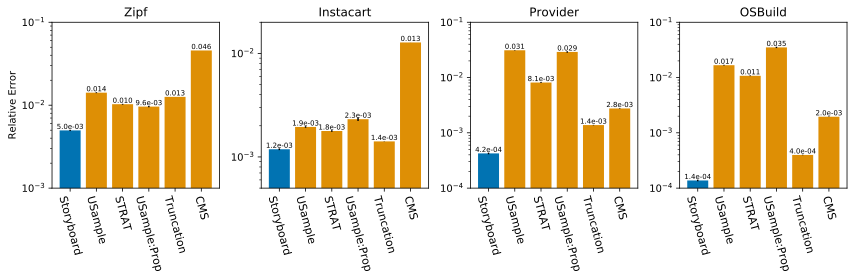

In [73]:
h_datasets = [
#     ("synthf@4", 2048), 
    ("bsynthf@4", 50000),
    ("insta", 300_000),
    ("msft_network_10M", 100_000),
    ("msft_os_10M", 100_000),
]


workload_p = .2
board_params = [
        ("pps", "weighted@20", True),
        ("random_sample", "uniform", False),
        ("random_sample", "sweighted@20", False),
        ("random_sample", "prop", False),
        ("truncation", "uniform", False),
        ("cms_min", "uniform", False),

#         ("pps", "uniform", True),
#         ("pps", "weighted@20", False),
#         ("random_sample", "weighted@20", True),
]

fig, axs = plt.subplots(figsize=(12,4), nrows=1, ncols=4, sharey=False, dpi=100)
plt.subplots_adjust(wspace=.25)

di = 0
lims = [
    (1e-3, 1e-1),
    (.5e-3, 2e-2),
    (1e-4, 1e-1),
    (1e-4, 1e-1),
]
labels = [method_names[i] for i in board_params]

for dataset_name, board_size in h_datasets:
    ax = axs[di]
    gen_cube_plots(
        dataset_name,
        board_size,
        workload_p,
        board_params,
        item_agg="max",
        ax=ax,
        vert=True,
        lab_size=7,
    )
    ax.set_title(data_display_name[dataset_name])
    ax.set_ylim(*lims[di])
    ax.set_yscale("log")
    di += 1
    ax.set_xticklabels(labels, rotation=-75, size=11)


ax = axs[0]
ax.set_ylabel("Relative Error")

fname1= "output/plots/cube_freq_global_n.pdf"
fig.tight_layout()
fig.savefig(fname1, bbox_inches='tight')

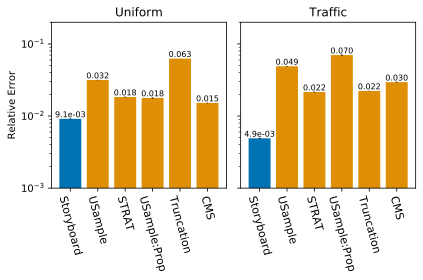

In [74]:
h_datasets = [
    ("bsynthq@4", 50_000),
    ("msft_records_10M", 50_000)
]

workload_p = .2
board_params = [
        ("q_pps", "weighted@20", False),
        ("q_random_sample", "uniform", False),
        ("q_random_sample", "sweighted@20", False),
        ("q_random_sample", "prop", False),
        ("q_truncation", "uniform", False),
        ("kll", "uniform", False),

#         ("q_pps", "uniform", False),
#         ("pps", "weighted@20", False),
#         ("random_sample", "weighted@20", True),
]

fig, axs = plt.subplots(figsize=(6,4), nrows=1, ncols=2, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
for dataset_name, board_size in h_datasets:
    ax = axs[di]
    gen_cube_plots(
        dataset_name,
        board_size,
        workload_p,
        board_params,
        item_agg="max",
        ax=ax,
        vert=True,
        lab_size=8
    )
    ax.set_title(data_display_name[dataset_name])
    di += 1
    ax.set_ylim(1e-3, 2e-1)
    ax.set_yscale("log")
    ax.set_xticklabels(labels, rotation=-75, size=11)
    
labels = [method_names[i] for i in board_params]
ax = axs[0]
ax.set_ylabel("Relative Error")


fname1= "output/plots/cube_quant_global_n.pdf"
fig.tight_layout()
fig.savefig(fname1, bbox_inches='tight')
    
# ax = axs[0]
# ax.set_yscale("log")
# ax.set_ylim(1e-3, 0.1)
# # ax.grid(axis="y", linestyle="--")
# ax.set_ylabel("Relative Error")

# fig.tight_layout()
# fname1= "output/plots/cube_quant_global.pdf"
# fig.savefig(fname1, bbox_inches='tight')

# Lesion Study

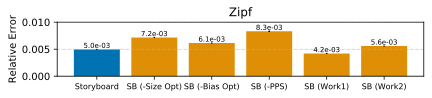

In [14]:
h_datasets = [
#     ("synthf@4", 2048), 
    ("bsynthf@4", 50000),
#     ("insta", 300_000)
]


workload_p = .2
board_params = [
        ("pps", "weighted@20", True),
#         ("random_sample", "uniform", False),
#         ("random_sample", "prop", False),
#         ("truncation", "uniform", False),
#         ("cms_min", "uniform", False),
        ("pps", "uniform", True),
        ("pps", "weighted@20", False),
        ("random_sample", "weighted@20", True),


        ("pps", "weighted@5", True),
        ("pps", "weighted@50", True),
]

fig = plt.figure(figsize=(6.2,1.5))
ax = fig.gca()
dataset_name, board_size = h_datasets[0]
gen_cube_plots(
    dataset_name,
    board_size,
    workload_p,
    board_params,
    item_agg="max",
    ax=ax,
    vert=True
)
ax.set_title(data_display_name[dataset_name])
# ax.set_yscale("log")
ax.set_ylim(0, 0.01)
ax.grid(axis="y", linestyle="-.", lw=.5)
ax.set_ylabel("Relative Error")
labels = [method_names[i] for i in board_params]
ax.set_xticklabels(labels, rotation = 0, ha="center", size=8)

# fig.tight_layout()
fname1= "output/plots/cube_freq_lesion.pdf"
fig.tight_layout()
fig.savefig(fname1, bbox_inches='tight')

# Vary Number Filters

In [19]:
def gen_query_plot(
    ax,
    data_name: str,
    board_size: int,
    workload_p: float,
    board_params: Sequence[Tuple],
    item_agg="max",
    query_agg="max",
):
    e_fnames = [
        get_error_file(
            data_name, 
            split_strategy=split_strategy,
            board_size=board_size, 
            sketch_name=sketch_name,
            bias=bias,
            workload_p=workload_p, 
        )
        for sketch_name,split_strategy,bias in board_params
    ]
    e_dfs = [pd.read_csv(f) for f in e_fnames]
    e_combined = pd.concat(e_dfs, axis=0)
    e_combined["err_n"] = e_combined[item_agg] / e_combined["total"]
    
    eg2 = e_combined.groupby(["sketch", "_split_strategy", "_bias_opt", "query_len"]).aggregate({
        "err_n": ["mean", "std", "count", "max"],
    })
    eg2["stde"] = eg2["err_n", "std"]/np.sqrt(eg2["err_n", "count"])
    
    for method_idx in board_params:
        cur_name = method_names[method_idx]
        ys = eg2["err_n", query_agg].loc[method_idx]
        yerrs = eg2["stde"].loc[method_idx]
#         yerrs = eg2["err_n", "std"].loc[method_idx]
        ax.errorbar(
            ys.index, ys, 
            yerr=yerrs, 
#             label=cur_name,
            color=colormap[method_idx],
            marker=markers[method_idx],
            lw=0,
        )
        ax.plot(
            ys.index, ys, 
#             yerr=yerrs, 
            label=cur_name,
            color=colormap[method_idx],
            marker=markers[method_idx],
            lw=.5,
        )

    # ax.yaxis.grid(True)
    ax.set_yscale("log")
    # ax.set_xticklabels(names, rotation=-55)
    ax.set_title(data_name)
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

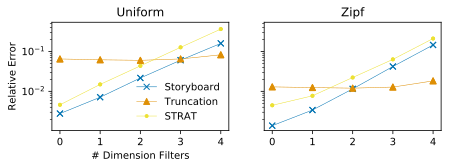

In [23]:
f_board_params = [
        ("pps", "weighted@20", True),
#         ("random_sample", "uniform", False),
#         ("random_sample", "prop", False),
        ("truncation", "uniform", False),
        ("random_sample", "sweighted@20", False),
#         ("cms_min", "uniform", False),

#         ("pps", "uniform", True),
#         ("pps", "weighted@20", False),
#         ("random_sample", "weighted@20", True),
]
q_board_params = [
        ("q_pps", "weighted@20", False),
        ("q_truncation", "uniform", False),
        ("q_random_sample", "sweighted@20", False),
]

workloads = [
    ("bsynthq@4", 50_000, True),
#     ("insta", 300_000, False),
    ("bsynthf@4", 50_000, False),
]

f,axs = plt.subplots(figsize=(7,2),ncols=2,sharey=True)
di = 0

for data_name, board_size, quantile in workloads:
    if quantile:
        board_params = q_board_params
    else:
        board_params = f_board_params
    workload_p = .2

    ax=axs[di]
    gen_query_plot(
        ax,
        data_name,
        board_size,
        workload_p,
        board_params,
        item_agg="max",
        query_agg="mean",
    )
    di += 1
    ax.set_title(data_display_name[data_name])
#     lgd = ax.legend(frameon=False)
axs[0].set_ylabel("Relative Error")
axs[0].set_xlabel("# Dimension Filters")
lgd = axs[0].legend(frameon=False)

# lgd = ax.legend(frameon=False)
# ax.set_ylim(10**-5, 2*)
# f.tight_layout()
# lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1, 1.3), ncol=3)
fname = "output/plots/cube_query_{}.pdf".format(data_name)
f.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')